 http://www.snap-tck.com/room04/c01/stat/stat01/stat0106.html#note03

In [1]:
using Logging
disable_logging(Logging.Warn)

using Distributions
using Roots
using Memoization
using Plots
using RCall
@rlibrary stats

x ⪅ y = x < y || x ≈ y

function pvalue(d, k, ::Val{:ts}) # :ts stands for "two-sided"
    sum(pdf(d, j) for j in support(d) if pdf(d, j) ⪅ pdf(d, k); init = 0.0)
end

function pvalue(d, k, ::Val{:dos}) # :dos stands for "doubled one-sided"
    min(1, 2cdf(d, k), 2ccdf(d, k-1))
end

@memoize function pvalue(a, b, c, d, ::Val{:fisher}; ω = 1.0)
    (iszero(a+c) || iszero(b+d) || iszero(a+b) || iszero(c+d)) && return 1.0
    pvalue(FisherNoncentralHypergeometric(a+b, c+d, a+c, ω), a, Val(:ts))
end

@memoize function pvalue(a, b, c, d, ::Val{:fisher_dos}; ω = 1.0)
    (iszero(a+c) || iszero(b+d) || iszero(a+b) || iszero(c+d)) && return 1.0
    pvalue(FisherNoncentralHypergeometric(a+b, c+d, a+c, ω), a, Val(:dos))
end

function delta(a, b, c, d, ω=1.0)
    A = 1 - ω
    B = a + d + ω*(b + c)
    C = a*d - ω*b*c
    2*C/(-B - √(B^2 - 4*A*C))
end

_odds_ratio(a, b, c, d) = (ad = a*d; iszero(ad) ? ad : ad/(b*c))
function odds_ratio(a, b, c, d, ω=1.0)
    δ = delta(a, b, c, d, ω)
    _odds_ratio(a + δ, b - δ, c - δ, d + δ)
end

_chisq(a, b, c, d) = (a+b+c+d)*(a*d - b*c)^2/((a+b)*(c+d)*(a+c)*(b+d))
function chisq(a, b, c, d, ω=1.0)
    δ = delta(a, b, c, d, ω)
    iszero(δ) ? δ : δ^2 * (1/(a + δ) + 1/(b - δ) + 1/(c - δ) + 1/(d + δ))
end

function chisq_yates(a, b, c, d, ω=1.0)
    δ = delta(a, b, c, d, ω)
    m = max(0, abs(δ)-1/2)^2
    iszero(m) ? m : m * (1/(a + δ) + 1/(b - δ) + 1/(c - δ) + 1/(d + δ))
end

@memoize function pvalue(a, b, c, d, ::Val{:chisq}; ω = 1.0)
    ccdf(Chisq(1), chisq(a, b, c, d, ω))
end

@memoize function pvalue(a, b, c, d, ::Val{:chisq_yates}; ω = 1.0)
    ccdf(Chisq(1), chisq_yates(a, b, c, d, ω))
end

@memoize function confidence_interval(a, b, c, d, alg; α = 0.05)
    CI = exp.(find_zeros(t -> pvalue(a, b, c, d, alg; ω = exp(t)) - α, -20, 20))
    or = _odds_ratio(a, b, c, d)
    iszero(or) && return (0.0, CI[1])
    isinf(or)  && return (CI[1], Inf)
    isone(length(CI)) ? CI[1] < 1 ? (0.0, CI[1]) : (CI[1], Inf) : (CI[1], CI[end])
end

confidence_interval (generic function with 1 method)

In [2]:
println("="^30 * " Test data:\n")

A = [16 4; 4 6]
@show A
println()

println("="^30 * " Calculated by R:\n")
@show rcopy(fisher_test(A))[:p_value]
@show rcopy(fisher_test(A))[:conf_int]
println()
@show rcopy(chisq_test(A, correct=false))[:p_value]
@show rcopy(chisq_test(A))[:p_value]

flush(stdout)
println()

println("="^30 * " Calculated by Julia:\n")
@show pvalue(A..., Val(:fisher))
@show confidence_interval(A..., Val(:fisher))
@show pvalue(A..., Val(:fisher_dos))
@show confidence_interval(A..., Val(:fisher_dos))
println()
@show pvalue(A..., Val(:chisq))
@show confidence_interval(A..., Val(:chisq))
@show pvalue(A..., Val(:chisq_yates))
@show confidence_interval(A..., Val(:chisq_yates))
;

============================== Test data:

A = [16 4; 4 6]

============================== Calculated by R:

(rcopy(fisher_test(A)))[:p_value] = 0.04485792401834373
(rcopy(fisher_test(A)))[:conf_int] = [0.8602909481155422, 44.00171912708482]

(rcopy(chisq_test(A, correct = false)))[:p_value] = 0.028459736916310548
(rcopy(chisq_test(A)))[:p_value] = 0.07505987281783368

============================== Calculated by Julia:

pvalue(A..., Val(:fisher)) = 0.04485792401834382
confidence_interval(A..., Val(:fisher)) = (1.0548936562756734, 32.69944128327747)
pvalue(A..., Val(:fisher_dos)) = 0.07741723543822498
confidence_interval(A..., Val(:fisher_dos)) = (0.8602702455780803, 43.98182262822144)

pvalue(A..., Val(:chisq)) = 0.028459736916310548
confidence_interval(A..., Val(:chisq)) = (1.1911176901272547, 30.49633585876286)
pvalue(A..., Val(:chisq_yates)) = 0.07505987281783368
confidence_interval(A..., Val(:chisq_yates)) = (0.8734133287988821, 47.22191280527806)


In [3]:
fisher_test(A)

RObject{VecSxp}

	Fisher's Exact Test for Count Data

data:  structure(c(16L, 4L, 4L, 6L), .Dim = c(2L, 2L))
p-value = 0.04486
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  0.8602909 44.0017191
sample estimates:
odds ratio 
  5.585888 



In [4]:
chisq_test(A, correct = false)

RObject{VecSxp}

	Pearson's Chi-squared test

data:  structure(c(16L, 4L, 4L, 6L), .Dim = c(2L, 2L))
X-squared = 4.8, df = 1, p-value = 0.02846



In [5]:
chisq_test(A)

RObject{VecSxp}

	Pearson's Chi-squared test with Yates' continuity correction

data:  structure(c(16L, 4L, 4L, 6L), .Dim = c(2L, 2L))
X-squared = 3.1687, df = 1, p-value = 0.07506



In [6]:
function dnhyper(a, b, c, d, ncp)
    nchg = FisherNoncentralHypergeometric(a+b, c+d, a+c, ncp)
    supp = support(nchg)
    pdf.(nchg, supp)
end

# https://github.com/SurajGupta/r-source/blob/master/src/library/stats/R/fisher.test.R#L132
# https://stat.ethz.ch/R-manual/R-devel/library/stats/html/Hypergeometric.html
function dnhyper_R(a, b, c, d, ncp)
    hg = Hypergeometric(a+b, c+d, a+c)
    supp = support(hg)
    logdc = logpdf.(hg, supp)
    d = @. logdc + log(ncp) * supp
    m = maximum(d)
    d = @. exp(d - m)
    d ./ sum(d)
end

f(ncp) = dnhyper(A..., ncp)
g(ncp) = dnhyper_R(A..., ncp)
@show round.(f(0.5) ./ g(0.5); digits=5)
@show round.(f(1.0) ./ g(1.0); digits=5)
@show round.(f(2.0) ./ g(2.0); digits=5);

round.(f(0.5) ./ g(0.5); digits = 5) = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
round.(f(1.0) ./ g(1.0); digits = 5) = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
round.(f(2.0) ./ g(2.0); digits = 5) = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [7]:
# https://github.com/SurajGupta/r-source/blob/master/src/library/stats/R/fisher.test.R#L208
# https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/uniroot
# https://github.com/SurajGupta/r-source/blob/master/src/library/stats/R/nlm.R#L60
# `tol = .Machine$double.eps^0.25`

@show rcopy(R".Machine$double.eps^0.25")
@show d = eps()^0.25
@show CI_R = rcopy(fisher_test(A))[:conf_int]
@show CI = confidence_interval(A..., Val(:fisher_dos))
@show log.(CI_R ./ CI);

rcopy(R".Machine$double.eps^0.25") = 0.0001220703125
d = eps() ^ 0.25 = 0.0001220703125
CI_R = (rcopy(fisher_test(A)))[:conf_int] = [0.8602909481155422, 44.00171912708482]
CI = confidence_interval(A..., Val(:fisher_dos)) = (0.8602702455780803, 43.98182262822144)
log.(CI_R ./ CI) = [2.4064866206256525e-5, 0.0004522777511702246]


In [8]:
ecdf(A, x) = count(≤(x), A)/length(A)

function multinomial_null(a, b, c, d)
    n = a + b + c + d
    pa = (a+b)*(a+c)/n^2
    pb = (a+b)*(b+d)/n^2
    pc = (c+d)*(a+c)/n^2
    pd = (c+d)*(b+d)/n^2
    Multinomial(n, [pa, pb, pc, pd])
end

null = multinomial_null(A...)
L = 10^5
X = rand(null, L)
@time pvalue_fisher = vec(mapslices(A -> pvalue(A..., Val(:fisher)), X; dims=1))
@time pvalue_fisher_dos = vec(mapslices(A -> pvalue(A..., Val(:fisher_dos)), X; dims=1))
@time pvalue_chisq = vec(mapslices(A -> pvalue(A..., Val(:chisq)), X; dims=1))
@time pvalue_chisq_yates = vec(mapslices(A -> pvalue(A..., Val(:chisq_yates)), X; dims=1));

  0.883117 seconds (3.99 M allocations: 197.857 MiB, 5.29% gc time, 91.98% compilation time)
  0.185732 seconds (1.59 M allocations: 49.574 MiB, 7.47% gc time, 64.08% compilation time)
  0.190985 seconds (1.56 M allocations: 47.908 MiB, 8.11% gc time, 61.01% compilation time)
  0.152232 seconds (1.49 M allocations: 42.959 MiB, 62.17% compilation time)


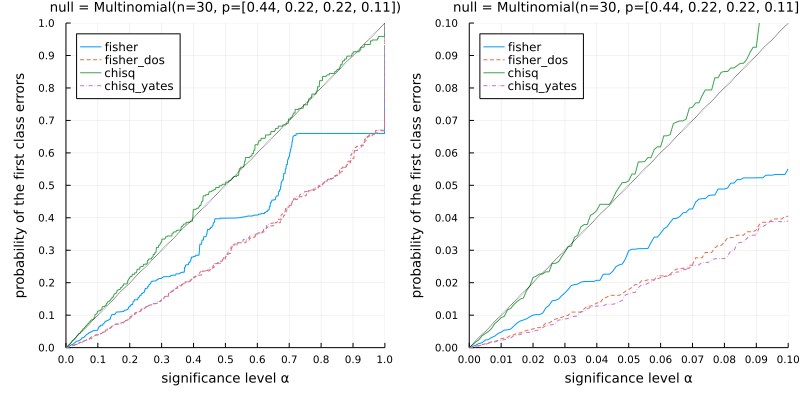

In [9]:
p = range(0, 1; length=1001)
P = plot()
plot!(p, p -> ecdf(pvalue_fisher, p); label="fisher")
plot!(p, p -> ecdf(pvalue_fisher_dos, p); label="fisher_dos", ls=:dash)
plot!(p, p -> ecdf(pvalue_chisq, p); label="chisq")
plot!(p, p -> ecdf(pvalue_chisq_yates, p); label="chisq_yates", ls=:dashdot)
plot!([0, maximum(p)], [0, maximum(p)]; label="", color=:black, ls=:dot)
plot!(; xlim=extrema(p), ylim=extrema(p))
plot!(; size=(400, 400), legend=:topleft)
plot!(; xlabel="significance level α", ylabel="probability of the first class errors")
plot!(; xtick=range(extrema(p)...; length=11), ytick=range(extrema(p)...; length=11), tickfontsize=7, guidefontsize=9)
plot!(; title="null = Multinomial(n=$(ntrials(null)), p=$(round.(probs(null); digits=2)))", titlefontsize=9)

p = range(0, 0.1; length=101)
Q = plot()
plot!(p, p -> ecdf(pvalue_fisher, p); label="fisher")
plot!(p, p -> ecdf(pvalue_fisher_dos, p); label="fisher_dos", ls=:dash)
plot!(p, p -> ecdf(pvalue_chisq, p); label="chisq")
plot!(p, p -> ecdf(pvalue_chisq_yates, p); label="chisq_yates", ls=:dashdot)
plot!([0, maximum(p)], [0, maximum(p)]; label="", color=:black, ls=:dot)
plot!(; xlim=extrema(p), ylim=extrema(p))
plot!(; size=(400, 400), legend=:topleft)
plot!(; xlabel="significance level α", ylabel="probability of the first class errors")
plot!(; xtick=range(extrema(p)...; length=11), ytick=range(extrema(p)...; length=11), tickfontsize=7, guidefontsize=9)
plot!(; title="null = Multinomial(n=$(ntrials(null)), p=$(round.(probs(null); digits=2)))", titlefontsize=9)

plot(P, Q; size=(800, 400), left_margin=5Plots.mm, bottom_margin=5Plots.mm)

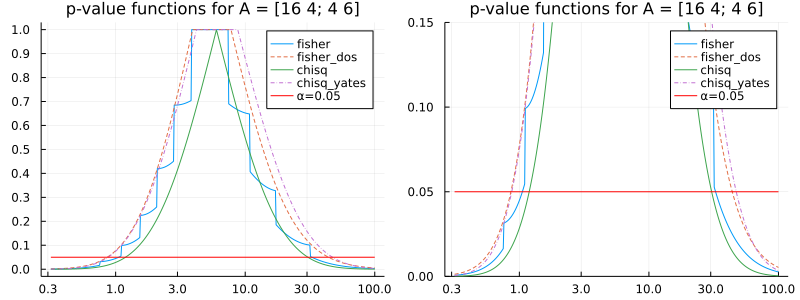

In [10]:
logω = range(-0.5, 2.0; length=500)
P = plot()
plot!(logω, t -> pvalue(A..., Val(:fisher); ω=10^t); label="fisher")
plot!(logω, t -> pvalue(A..., Val(:fisher_dos); ω=10^t); label="fisher_dos", ls=:dash)
plot!(logω, t -> pvalue(A..., Val(:chisq); ω=10^t); label="chisq")
plot!(logω, t -> pvalue(A..., Val(:chisq_yates); ω=10^t); label="chisq_yates", ls=:dashdot)
plot!(logω, 0.05ones(length(logω)); label="α=0.05", color=:red)
#plot!(; legend=:topleft)
x = [0.3, 1.0, 3.0, 10.0, 30.0, 100.0]
plot!(; xtick = (log10.(x), string.(x)), ytick=0:0.1:1)
plot!(; title="p-value functions for A = $A", titlefontsize=11)

Q = deepcopy(P)
plot!(Q; ylim=(0, 0.15), ytick=0:0.05:1)

plot(P, Q; size=(800, 300))

https://twitter.com/myuuuuun/status/1428579692219490304?s=21

In [11]:
println("="^30 * " Test data:\n")

a, b, c, d = 83207-1557, 1557, 317-1, 1
A = [a b; c d]
@show A
println()

println("="^30 * " Calculated by R:\n")
@show rcopy(fisher_test(A))[:p_value]
@show rcopy(fisher_test(A))[:conf_int]
println()
@show rcopy(chisq_test(A, correct=false))[:p_value]
@show rcopy(chisq_test(A))[:p_value]

sleep(0.1)
println()

println("="^30 * " Calculated by Julia:\n")
@show pvalue(A..., Val(:fisher))
@show confidence_interval(A..., Val(:fisher))
@show pvalue(A..., Val(:fisher_dos))
@show confidence_interval(A..., Val(:fisher_dos))
println()
@show pvalue(A..., Val(:chisq))
@show confidence_interval(A..., Val(:chisq))
@show pvalue(A..., Val(:chisq_yates))
@show confidence_interval(A..., Val(:chisq_yates))
;

============================== Test data:

A = [81650 1557; 316 1]

============================== Calculated by R:

(rcopy(fisher_test(A)))[:p_value] = 0.034839286728928866
(rcopy(fisher_test(A)))[:conf_int] = [0.004189193856121582, 0.9327461541123404]

(rcopy(chisq_test(A, correct = false)))[:p_value] = 0.0410085618759163
(rcopy(chisq_test(A)))[:p_value] = 0.06643387655532222

============================== Calculated by Julia:

pvalue(A..., Val(:fisher)) = 0.034839286728928595
confidence_interval(A..., Val(:fisher)) = (0.008480714932286545, 0.9719200961864988)
pvalue(A..., Val(:fisher_dos)) = 0.035637096256844566
confidence_interval(A..., Val(:fisher_dos)) = (0.00418578100428889, 0.9327256820962865)

pvalue(A..., Val(:chisq)) = 0.0410085618759163
confidence_interval(A..., Val(:chisq)) = (0.02921634942093311, 0.9426442790969732)
pvalue(A..., Val(:chisq_yates)) = 0.06643387655532222
confidence_interval(A..., Val(:chisq_yates)) = (0.008632811624783469, 1.0838248932441237)


In [12]:
a, b, c, d = 83207-1557, 1557, 317-1, 1
A = [a b; c d]

null = multinomial_null(A...)
L = 10^5
X = rand(null, L)
@time pvalue_fisher = vec(mapslices(A -> pvalue(A..., Val(:fisher)), X; dims=1))
@time pvalue_fisher_dos = vec(mapslices(A -> pvalue(A..., Val(:fisher_dos)), X; dims=1))
@time pvalue_chisq = vec(mapslices(A -> pvalue(A..., Val(:chisq)), X; dims=1))
@time pvalue_chisq_yates = vec(mapslices(A -> pvalue(A..., Val(:chisq_yates)), X; dims=1));

 17.765432 seconds (1.87 M allocations: 55.095 MiB, 0.58% compilation time)
  0.203982 seconds (1.83 M allocations: 48.280 MiB, 13.02% gc time, 57.21% compilation time)
  0.217965 seconds (1.83 M allocations: 48.282 MiB, 17.61% gc time, 40.34% compilation time)
  0.275516 seconds (1.83 M allocations: 56.278 MiB, 33.73% compilation time)


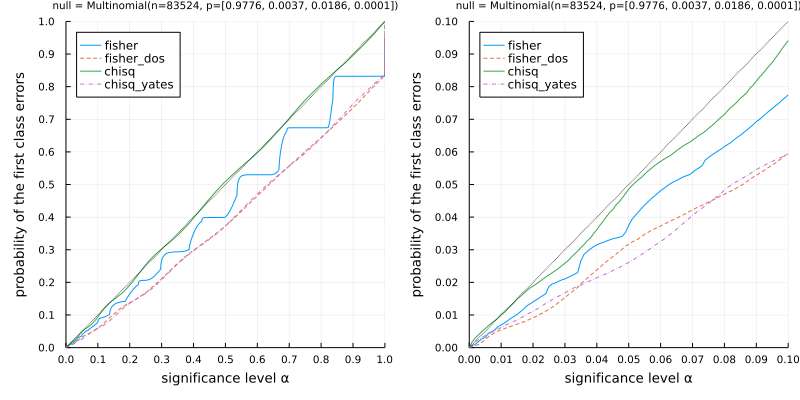

In [13]:
p = range(0, 1; length=1001)
P = plot()
plot!(p, p -> ecdf(pvalue_fisher, p); label="fisher")
plot!(p, p -> ecdf(pvalue_fisher_dos, p); label="fisher_dos", ls=:dash)
plot!(p, p -> ecdf(pvalue_chisq, p); label="chisq")
plot!(p, p -> ecdf(pvalue_chisq_yates, p); label="chisq_yates", ls=:dashdot)
plot!([0, maximum(p)], [0, maximum(p)]; label="", color=:black, ls=:dot)
plot!(; xlim=extrema(p), ylim=extrema(p))
plot!(; size=(400, 400), legend=:topleft)
plot!(; xlabel="significance level α", ylabel="probability of the first class errors")
plot!(; xtick=range(extrema(p)...; length=11), ytick=range(extrema(p)...; length=11), tickfontsize=7, guidefontsize=9)
plot!(; title="null = Multinomial(n=$(ntrials(null)), p=$(round.(probs(null); digits=4)))", titlefontsize=7)

p = range(0, 0.1; length=101)
Q = plot()
plot!(p, p -> ecdf(pvalue_fisher, p); label="fisher")
plot!(p, p -> ecdf(pvalue_fisher_dos, p); label="fisher_dos", ls=:dash)
plot!(p, p -> ecdf(pvalue_chisq, p); label="chisq")
plot!(p, p -> ecdf(pvalue_chisq_yates, p); label="chisq_yates", ls=:dashdot)
plot!([0, maximum(p)], [0, maximum(p)]; label="", color=:black, ls=:dot)
plot!(; xlim=extrema(p), ylim=extrema(p))
plot!(; size=(400, 400), legend=:topleft)
plot!(; xlabel="significance level α", ylabel="probability of the first class errors")
plot!(; xtick=range(extrema(p)...; length=11), ytick=range(extrema(p)...; length=11), tickfontsize=7, guidefontsize=9)
plot!(; title="null = Multinomial(n=$(ntrials(null)), p=$(round.(probs(null); digits=4)))", titlefontsize=7)

plot(P, Q; size=(800, 400), left_margin=5Plots.mm, bottom_margin=5Plots.mm)

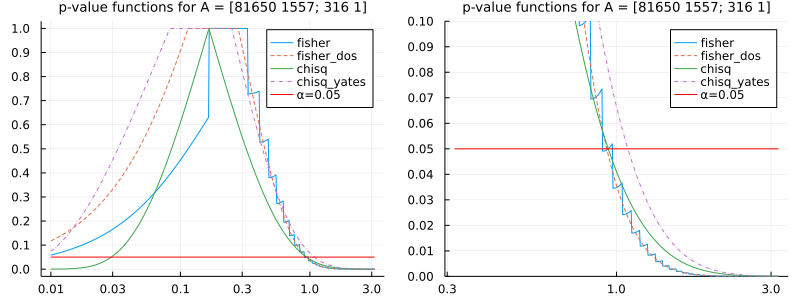

In [14]:
logω = range(-2.0, 0.5; length=500)
P = plot()
plot!(logω, t -> pvalue(A..., Val(:fisher); ω=10^t); label="fisher")
plot!(logω, t -> pvalue(A..., Val(:fisher_dos); ω=10^t); label="fisher_dos", ls=:dash)
plot!(logω, t -> pvalue(A..., Val(:chisq); ω=10^t); label="chisq")
plot!(logω, t -> pvalue(A..., Val(:chisq_yates); ω=10^t); label="chisq_yates", ls=:dashdot)
plot!(logω, 0.05ones(length(logω)); label="α=0.05", color=:red)
#plot!(; legend=:topleft)
x = [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]
plot!(; xtick = (log10.(x), string.(x)), ytick=0:0.1:1)
plot!(; title="p-value functions for A = $A", titlefontsize=9)

logω = range(-0.5, 0.5; length=500)
Q = plot()
plot!(logω, t -> pvalue(A..., Val(:fisher); ω=10^t); label="fisher")
plot!(logω, t -> pvalue(A..., Val(:fisher_dos); ω=10^t); label="fisher_dos", ls=:dash)
plot!(logω, t -> pvalue(A..., Val(:chisq); ω=10^t); label="chisq")
plot!(logω, t -> pvalue(A..., Val(:chisq_yates); ω=10^t); label="chisq_yates", ls=:dashdot)
plot!(logω, 0.05ones(length(logω)); label="α=0.05", color=:red)
#plot!(; legend=:topleft)
x = [0.3, 1.0, 3.0]
plot!(; xtick = (log10.(x), string.(x)), ylim=(0, 0.1), ytick=0:0.01:1)
plot!(; title="p-value functions for A = $A", titlefontsize=9)

plot(P, Q; size=(800, 300))

* https://www3.nhk.or.jp/kansai-news/20210921/2000051589.html
* https://twitter.com/holyeightturtle/status/1440708315030306824

In [15]:
println("="^30 * " Test data:\n")

A = [
    14-0   0
    833-78 78
]
@show A
println()

println("="^30 * " Calculated by R:\n")
@show rcopy(fisher_test(A))[:p_value]
@show rcopy(fisher_test(A))[:conf_int]
println()
@show rcopy(chisq_test(A, correct=false))[:p_value]
@show rcopy(chisq_test(A))[:p_value]

flush(stdout)
println()

println("="^30 * " Calculated by Julia:\n")
@show pvalue(A..., Val(:fisher))
@show confidence_interval(A..., Val(:fisher))
@show pvalue(A..., Val(:fisher_dos))
@show confidence_interval(A..., Val(:fisher_dos))
println()
@show pvalue(A..., Val(:chisq))
@show confidence_interval(A..., Val(:chisq))
@show pvalue(A..., Val(:chisq_yates))
@show confidence_interval(A..., Val(:chisq_yates))
;

============================== Test data:

A = [14 0; 755 78]

============================== Calculated by R:

(rcopy(fisher_test(A)))[:p_value] = 0.6305840634204475
(rcopy(fisher_test(A)))[:conf_int] = [0.33501504778126484, Inf]

(rcopy(chisq_test(A, correct = false)))[:p_value] = 0.22951056861171096
(rcopy(chisq_test(A)))[:p_value] = 0.4619696191640533

============================== Calculated by Julia:

pvalue(A..., Val(:fisher)) = 0.6305840634204476
confidence_interval(A..., Val(:fisher)) = (0.3779843893116254, Inf)
pvalue(A..., Val(:fisher_dos)) = 0.5114989891101491
confidence_interval(A..., Val(:fisher_dos)) = (0.33500290340512084, Inf)

pvalue(A..., Val(:chisq)) = 0.22951056861171087
confidence_interval(A..., Val(:chisq)) = (0.37319823559179843, Inf)
pvalue(A..., Val(:chisq_yates)) = 0.4619696191640533
confidence_interval(A..., Val(:chisq_yates)) = (0.27683453676738023, Inf)


In [16]:
A = [
    14-0   0
    833-78 78
]

null = multinomial_null(A...)
L = 10^5
X = rand(null, L)
@time pvalue_fisher = vec(mapslices(A -> pvalue(A..., Val(:fisher)), X; dims=1))
@time pvalue_fisher_dos = vec(mapslices(A -> pvalue(A..., Val(:fisher_dos)), X; dims=1))
@time pvalue_chisq = vec(mapslices(A -> pvalue(A..., Val(:chisq)), X; dims=1))
@time pvalue_chisq_yates = vec(mapslices(A -> pvalue(A..., Val(:chisq_yates)), X; dims=1));

  0.203012 seconds (1.66 M allocations: 46.884 MiB, 47.37% compilation time)
  0.325104 seconds (1.56 M allocations: 42.535 MiB, 52.01% gc time, 82.48% compilation time)
  0.153249 seconds (1.56 M allocations: 42.538 MiB, 58.95% compilation time)
  0.214073 seconds (1.56 M allocations: 42.535 MiB, 15.31% gc time, 44.25% compilation time)


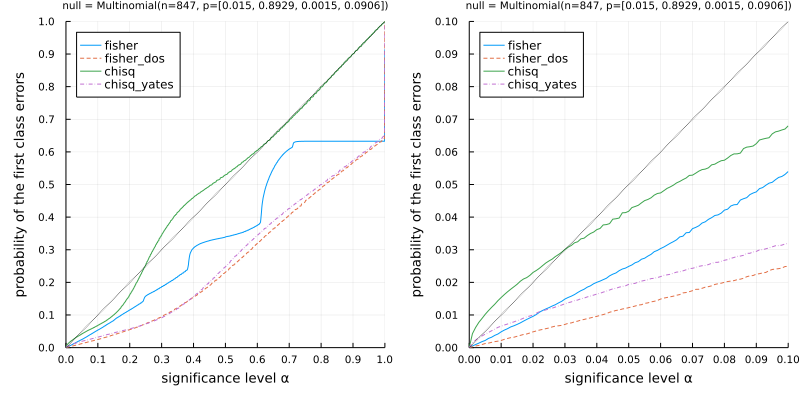

In [17]:
p = range(0, 1; length=1001)
P = plot()
plot!(p, p -> ecdf(pvalue_fisher, p); label="fisher")
plot!(p, p -> ecdf(pvalue_fisher_dos, p); label="fisher_dos", ls=:dash)
plot!(p, p -> ecdf(pvalue_chisq, p); label="chisq")
plot!(p, p -> ecdf(pvalue_chisq_yates, p); label="chisq_yates", ls=:dashdot)
plot!([0, maximum(p)], [0, maximum(p)]; label="", color=:black, ls=:dot)
plot!(; xlim=extrema(p), ylim=extrema(p))
plot!(; size=(400, 400), legend=:topleft)
plot!(; xlabel="significance level α", ylabel="probability of the first class errors")
plot!(; xtick=range(extrema(p)...; length=11), ytick=range(extrema(p)...; length=11), tickfontsize=7, guidefontsize=9)
plot!(; title="null = Multinomial(n=$(ntrials(null)), p=$(round.(probs(null); digits=4)))", titlefontsize=7)

p = range(0, 0.1; length=101)
Q = plot()
plot!(p, p -> ecdf(pvalue_fisher, p); label="fisher")
plot!(p, p -> ecdf(pvalue_fisher_dos, p); label="fisher_dos", ls=:dash)
plot!(p, p -> ecdf(pvalue_chisq, p); label="chisq")
plot!(p, p -> ecdf(pvalue_chisq_yates, p); label="chisq_yates", ls=:dashdot)
plot!([0, maximum(p)], [0, maximum(p)]; label="", color=:black, ls=:dot)
plot!(; xlim=extrema(p), ylim=extrema(p))
plot!(; size=(400, 400), legend=:topleft)
plot!(; xlabel="significance level α", ylabel="probability of the first class errors")
plot!(; xtick=range(extrema(p)...; length=11), ytick=range(extrema(p)...; length=11), tickfontsize=7, guidefontsize=9)
plot!(; title="null = Multinomial(n=$(ntrials(null)), p=$(round.(probs(null); digits=4)))", titlefontsize=7)

plot(P, Q; size=(800, 400), left_margin=5Plots.mm, bottom_margin=5Plots.mm)

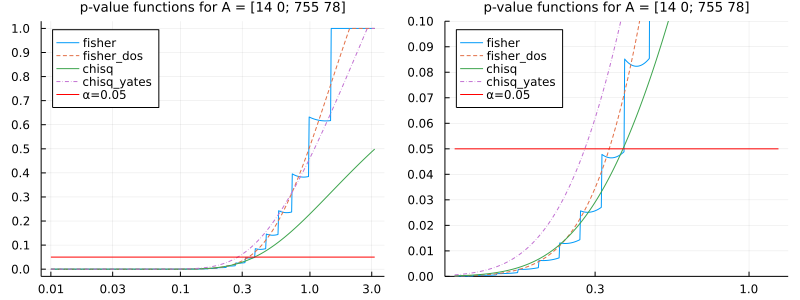

In [18]:
logω = range(-2.0, 0.5; length=500)
P = plot()
plot!(logω, t -> pvalue(A..., Val(:fisher); ω=10^t); label="fisher")
plot!(logω, t -> pvalue(A..., Val(:fisher_dos); ω=10^t); label="fisher_dos", ls=:dash)
plot!(logω, t -> pvalue(A..., Val(:chisq); ω=10^t); label="chisq")
plot!(logω, t -> pvalue(A..., Val(:chisq_yates); ω=10^t); label="chisq_yates", ls=:dashdot)
plot!(logω, 0.05ones(length(logω)); label="α=0.05", color=:red)
plot!(; legend=:topleft)
x = [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]
plot!(; xtick = (log10.(x), string.(x)), ytick=0:0.1:1)
plot!(; title="p-value functions for A = $A", titlefontsize=9)

logω = range(-1.0, 0.1; length=500)
Q = plot()
plot!(logω, t -> pvalue(A..., Val(:fisher); ω=10^t); label="fisher")
plot!(logω, t -> pvalue(A..., Val(:fisher_dos); ω=10^t); label="fisher_dos", ls=:dash)
plot!(logω, t -> pvalue(A..., Val(:chisq); ω=10^t); label="chisq")
plot!(logω, t -> pvalue(A..., Val(:chisq_yates); ω=10^t); label="chisq_yates", ls=:dashdot)
plot!(logω, 0.05ones(length(logω)); label="α=0.05", color=:red)
plot!(; legend=:topleft)
x = [0.3, 1.0, 3.0]
plot!(; xtick = (log10.(x), string.(x)), ylim=(0, 0.1), ytick=0:0.01:1)
plot!(; title="p-value functions for A = $A", titlefontsize=9)

plot(P, Q; size=(800, 300))